In [1]:
import pandas as pd

In [23]:
# All importances are mean_absolute_error
# Scaling the scores to 1 before group averaging? Scores in one fold are not comparable to other folds.
testpath = '/scistor/ivm/jsn295/importance/1/-3/responsagg_separation.parquet'

In [68]:
def scale_scores(df):
    df.loc[:,(slice(None),'score')] = df.loc[:,(slice(None),'score')].apply(lambda series: series / series.min(), axis = 0)
    return df
dat_onesep = pd.read_parquet(testpath)

In [69]:
dat_mean = dat_onesep.groupby('fold').apply(scale_scores).groupby(dat_onesep.index.names[1:]).mean() # Scale to max score per fold before averaging scores
dat_onesep.loc[dat_onesep['singlepass','rank'] == 0,:]

singlepass  \
                                                                rank   
fold variable      timeagg lag separation clustid metric               
0    transp_europe 31      -34 -3         1       spatcov          0   
1    z500_europe   5       -8  -3         1       spatcov          0   
2    snowc_nhmin   7       -10 -3         2       spatcov          0   
3    t850_nhblock  21      -24 -3         2       spatcov          0   
4    t850_nhblock  21      -24 -3         2       spatcov          0   
5    z500_europe   3       -6  -3         2       mean             0   
6    sst_nhplus    15      -18 -3         10      spatcov          0   
7    t850_nhblock  21      -24 -3         2       spatcov          0   
8    sst_nhplus    31      -34 -3         2       mean             0   
9    t850_nhblock  21      -24 -3         2       spatcov          0   

                                                                    multipass  \
                                                              score      rank   
fold variable      timeagg lag separation clustid metric                        
0    transp_europe 31      -34 -3         1       spatcov  1.462070       0.0   
1    z500_europe   5       -8  -3         1       spatcov  1.409904       0.0   
2    snowc_nhmin   7       -10 -3         2       spatcov  1.378261       0.0   
3    t850_nhblock  21      -24 -3         2       spatcov  1.589272       0.0   
4    t850_nhblock  21      -24 -3         2       spatcov  1.357581       0.0   
5    z500_europe   3       -6  -3         2       mean     1.370825       0.0   
6    sst_nhplus    15      -18 -3         10      spatcov  1.601329       0.0   
7    t850_nhblock  21      -24 -3         2       spatcov  1.414443       0.0   
8    sst_nhplus    31      -34 -3         2       mean     1.500411       0.0   
9    t850_nhblock  21      -24 -3         2       spatcov  1.461348       0.0   

                                                                     
                                                              score  
fold variable      timeagg lag separation clustid metric             
0    transp_europe 31      -34 -3         1       spatcov  1.462070  
1    z500_europe   5       -8  -3         1       spatcov  1.409904  
2    snowc_nhmin   7       -10 -3         2       spatcov  1.378261  
3    t850_nhblock  21      -24 -3         2       spatcov  1.589272  
4    t850_nhblock  21      -24 -3         2       spatcov  1.357581  
5    z500_europe   3       -6  -3         2       mean     1.370825  
6    sst_nhplus    15      -18 -3         10      spatcov  1.601329  
7    t850_nhblock  21      -24 -3         2       spatcov  1.414443  
8    sst_nhplus    31      -34 -3         2       mean     1.500411  
9    t850_nhblock  21      -24 -3         2       spatcov  1.461348

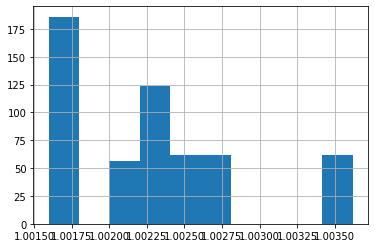

In [70]:
dat_mean['singlepass','score'].hist()

In [76]:
dat_mean.iloc[dat_mean['multipass','rank'].argmax(),:]

singlepass  rank     233.700000
            score      1.002116
multipass   rank       7.000000
            score      1.000000
Name: (snowc_nhmin, 21, -24, -3, 2, mean), dtype: float64

In [ ]:
# Perhaps replace the nan multipass ranks with just the shared worst possible?